# Exploratory Analysis Notebook
A set of tools to analyse the intents within your workspace.

**Author:** Kalyan Dutia (kalyan.dutia@ibm.com)

In [11]:
# external imports
import os
from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets
import pandas as pd
import numpy as np
import seaborn as sns
from itables import show

# internal imports
import config
import cli_tools.download_intents
from cli_tools.get_intent_intersections import intent_intersections
from for_csv.chi2_feat_select import chi2_feat_select

# config
sns.set_style("whitegrid")
sns.set_context("notebook")
pd.set_option('display.max_colwidth', -1)

## Get Training Data
This will be stored in the *data/workspace_training* folder, with the format [workspace-name]_questions.csv

### View existing data, import if necessary

First, view the files in the training data folder:

In [12]:
def view_training_files():
    training_files = [file for file in os.listdir(config.training_dir) if file.endswith('.csv')]
    training_files

    display(Markdown("**Training data files:**"))
    display(Markdown((''.join([' - {}\n'.format(i) for i in training_files]))))
    
    return training_files
        
training_files = view_training_files()

**Training data files:**

 - puppy_questions.csv
 - Customer Care Sample Skill_questions.csv


Then update them from Watson if necessary.

### Select a skill
Use the dropdown box, and use the following cell to confirm your selection.

In [29]:
def onchange(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output()
        display(d)
        display_sample(d, 10)

def display_sample(d, samplesize):
    if samplesize != None:
        display(Markdown("**<span style='color:blue'>{}</span>** skill selected. Training data sample:".format(d.value)))
    training_file = training_files[d.index]

    train_df = pd.read_csv(os.path.join(config.training_dir, training_file), names=['utterance', 'intent'])
    if (len(train_df) > 0) & (samplesize != None):
        display(train_df.sample(samplesize))
    elif samplesize:
        display(Markdown("<span style='color:red'>No intent training data exists for this workspace</span>"))
    
    return train_df

d = widgets.Dropdown(options=[item[0:len(item)-14] for item in training_files])
d.observe(onchange)

display(d)
train_df = display_sample(d, 10)


Dropdown(index=1, options=('puppy', 'Customer Care Sample Skill'), value='Customer Care Sample Skill')

**<span style='color:blue'>Customer Care Sample Skill</span>** skill selected. Training data sample:

,utterance,intent
84,I want to speak to a human,General_Connect_to_Agent
173,Could I speak to someone in the store next tuesday?,Customer_Care_Appointments
101,I need help with find a store,Customer_Care_Store_Location
163,can you assist me,Help
131,Hey twin,General_Greetings
48,representative,General_Connect_to_Agent
44,cancel that,Cancel
17,What time do you close,Customer_Care_Store_Hours
40,nevermind,Cancel
110,Find store,Customer_Care_Store_Location


## Analysis

### Intent Sizes
As a general rule of thumb, your intents should be sized relative to the amount of scope they cover. If this is not the case, you might want to check for redundancy in your intents later on.

If your largest intent is greater than two times your smallest, a warning will appear below.

**<span style='color:darkorange'>Warning:</span>** Your largest intent is 7.83x larger than your smallest

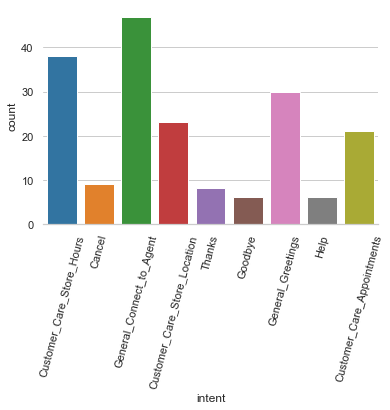

In [31]:
train_df = display_sample(d, None)
intent_sizes = train_df.groupby('intent').count()
intent_max_min_ratio = intent_sizes.max()[0] / intent_sizes.min()[0]

if intent_max_min_ratio > 2:
    display(Markdown("**<span style='color:darkorange'>Warning:</span>** Your largest intent is {}x larger than your smallest".format(round(intent_max_min_ratio, 2))))

ax = sns.countplot(data=train_df, x='intent')
ax.set_xticklabels(ax.get_xticklabels(), rotation=75);
sns.despine(left=True)

### Representative 1- and 2-grams
In this section we use chi-squared feature selection to bring out the terms which most represent each intent in your workspace. 

Here, you should be thinking about:
<ol type="a">
    <li>whether these terms are what you'd expect for each intent</li>
    <li>if any of these terms would be good candidates for resting entities</li>
</ol>

In [32]:
K=5

chi2 = chi2_feat_select(train_df)
chi2.getKbest(K)

,Cancel,Customer_Care_Appointments,Customer_Care_Store_Hours,Customer_Care_Store_Location,General_Connect_to_Agent,General_Greetings,Goodbye,Help,Thanks
top unigrams,"request, nevermind, forget, mind, cancel","face, week, available, make, appointment","time, late, close, hours, open","office, address, located, directions, location","connect, human, speak, talk, agent","going, hi, hello, good, hey","long, ya, ciao, arrivederci, bye","need, assist, assistance, decide, help","appreciated, thx, nice, thank, thanks"
top bigrams,"table anymore, anymore anymore, changed mind, cancel request, want cancel","face face, store appointment, like make, available week, make appointment","early open, late open, hours operation, open christmas, time close","help store, cross streets, nearest branch, looking location, like store","agent help, want agent, want speak, want talk, speak human","good evening, hi advisor, hey doing, good day, hello agent","speak human, don want, want talk, make appointment, good bye","don want, want talk, make appointment, need assistance, help decide","time close, speak human, don want, want talk, make appointment"


### Clashes between Intents
The matrix below shows the number of shared ngrams in utterances between intents. A high number means there is a greater overlap between the intents, which should be investigated.

In [42]:
ngram_list = [4,5] 
stopwords = 'none' # stopwords_in can be none, nltk, or config

In [43]:
ii = intent_intersections(ngram_list, stopwords_in=stopwords, intent_col='intent')
ii.import_training_df(train_df)
intersection_df, intersection_size_df = ii.calculate_ngram_intersections()

intersection_size_df = intersection_size_df.fillna(0)

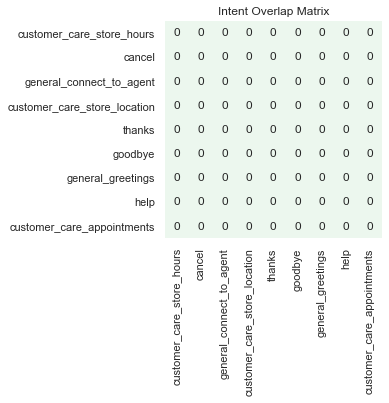

In [44]:
heatmap_colors = sns.cubehelix_palette(8, start=2, rot=0, dark=0.2, light=.95, reverse=False)
ax = sns.heatmap(intersection_size_df, annot=True, cmap=heatmap_colors, cbar=False, square=True)
ax.set_title('Intent Overlap Matrix');

You can then investigate specific intent overlaps:

In [45]:
def onchange(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output()
        display(d01)
        display(d02)
        display_intent_overlap(d01.value, d02.value)

def display_intent_overlap(intent1, intent2):
    if d01.value != d02.value:
        ngrams_per_intent_df, ngram_freq_df = ii.get_ngrams_per_intent()
        overlap_df = ii.get_intersection_freqs([intent1, intent2], ngram_freq_df)
        overlap_df = overlap_df.sort_values([intent1, intent2], ascending=False)
        display(overlap_df)
    else:
        display(Markdown("Intents chosen can't be the same"))

d01 = widgets.Dropdown(options=train_df['intent'].unique())
d02 = widgets.Dropdown(options=train_df['intent'].unique())

d01.observe(onchange)
d02.observe(onchange)

display(d01)
display(d02)
display_intent_overlap(d01.value, d02.value)

Dropdown(options=('customer_care_store_hours', 'cancel', 'general_connect_to_agent', 'customer_care_store_loca…

Dropdown(options=('customer_care_store_hours', 'cancel', 'general_connect_to_agent', 'customer_care_store_loca…

Intents chosen can't be the same

In [46]:
display(Markdown("You can use the table below to search through training utterances."))
show(train_df[['utterance', 'intent']])

You can use the table below to search through training utterances.

utterance,intent
